# Influence of Gender on Education Skill Proficiency

In the last question we will look at the influence of gender on the skill proficiency.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import edstats_utils as edstats
import economic_utils as ecstats
%matplotlib inline

# some pandas options
pd.set_option('display.max_colwidth', -1)

# load the relevant data
edpath = "./datasets/edstats"
df_country = pd.read_csv(os.path.join(edpath, "EdStatsCountry.csv"))
df_data = pd.read_csv(os.path.join(edpath, "EdStatsData.csv"))
df_series = pd.read_csv(os.path.join(edpath, "EdStatsSeries.csv"))
df_note = pd.read_csv(os.path.join(edpath, "EdStatsFootNote.csv"))
df_cseries = pd.read_csv(os.path.join(edpath, "EdStatsCountry-Series.csv"))

In [2]:
df_adult_prof = edstats.retrieve_skill_piaac(df_data)
df_ed_years = edstats.retrieve_education_length(df_data)

# load relevant indicators
df_gdp = ecstats.retrieve_gdp()
df_gdp_pc = ecstats.retrieve_gdp_pc()
df_eduspend = ecstats.retrieve_education_spending()
df_income20 = ecstats.retrieve_income()

In [3]:
# clean the dataset and add the region
ls_adult_years = ['2012', '2015']
df_adpr_clean = edstats.filter_years(df_adult_prof, ls_adult_years).dropna(axis=1, how='all')
df_adpr_clean = df_adpr_clean[df_adpr_clean.iloc[:, 4:6].isnull().min(axis=1) == False]
df_adpr_clean = edstats.append_region(df_adpr_clean, df_country)

# create year dataset
df_years = edstats.append_region(df_ed_years.dropna(axis=1, how='all'), df_country)
df_years = df_years[df_years.iloc[:, 4:-1].isnull().max(axis=1) == False]
ls_year_inds = ['SE.SEC.DURS.LO', 'UIS.THDUR.0', 'SE.PRM.DURS', 'SE.SEC.DURS.UP']

# retrieve education length and skill proficiency for 2012
df_years12 = df_years[['Country Name', 'Country Code', 'Indicator Name', '2012', 'Region']][df_years['Indicator Code'].isin(ls_year_inds)]
df_years12 = df_years12.groupby(['Country Name', 'Region', 'Country Code']).sum().reset_index()
df_prof12 = df_adpr_clean[['Country Name', 'Country Code', 'gender', 'subject', 'level', 'Region', '2012']]

# merge the data
df_12 = pd.merge(df_prof12, df_years12, on='Country Code')[['Country Name_x', 'Country Code', 'Region_x', 'gender', 'subject', 'level', '2012_x', '2012_y']].rename(columns={
    'Country Name_x':'country_name',
    'Country Code':'country_code',
    'Region_x': 'region',
    '2012_x':'ppl_perc',
    '2012_y':'edu_length'}).replace('problem solving in technology-rich environments', 'tech problems')

In [4]:
# clean all the data
df_gdp_clean = edstats.append_region(df_gdp.dropna(axis=1, how='all'), df_country)
df_gdppc_clean = edstats.append_region(df_gdp_pc.dropna(axis=1, how='all'), df_country)
df_eduspend_clean = edstats.append_region(df_eduspend.dropna(axis=1, how='all'), df_country)
df_income20_clean = edstats.append_region(df_income20.dropna(axis=1, how='all'), df_country)

# combine 
df_eduspend_total = pd.merge(df_eduspend_clean[['Country Code']], df_gdppc_clean, on="Country Code")
df_tmp = df_eduspend_clean.iloc[:, 4:-1].combine(df_eduspend_total.iloc[:, 4:-1], lambda s1, s2: (s1/100)*s2, overwrite=True).dropna(axis=1, how='all')
df_eduspend_total = pd.concat([df_eduspend_clean[['Country Code', 'Country Name', 'Region']], df_tmp], axis=1)

# interpolate the education data
df_eduspend_total_ip = pd.concat([
    df_eduspend_total.iloc[:, :3],
    df_eduspend_total.iloc[:, 3:].interpolate(method='linear', axis=1),
], axis=1)
# interpolate the income data
df_income20_ip = pd.concat([
    df_income20_clean[['Country Name', 'Country Code', 'Region']],
    df_income20_clean.iloc[:, 4:-1].interpolate(method='linear', axis=1) / 100,
], axis=1)

Now that we have loaded all data, lets analyse the gender gap.

> BAR CHART: Per skill level male vs female

> Categorize: High, Medium, Low Skill - Calculate Percentage of skills

> Plot scatter over education length (x) and percent (y) colored by region (for each of the three levels - or use different markers)

## Gender Skill Comparision

Lets compare the skill levels on a global level and break it down to regional levels

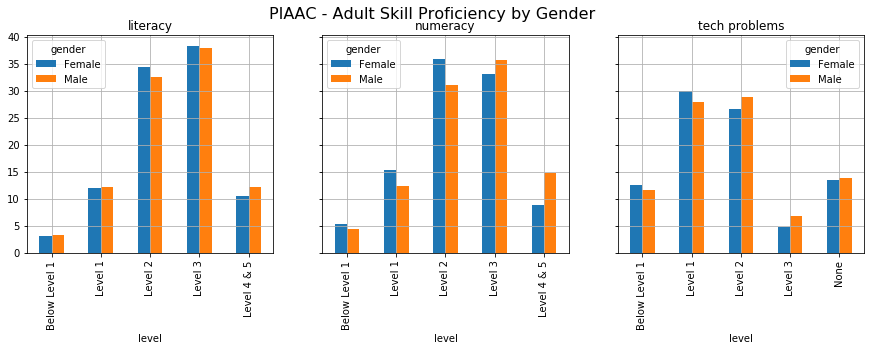

In [21]:
ls_subs = df_12['subject'].unique()
ls_gnds = ['Male', 'Female']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
for i, sub in enumerate(ls_subs):
    # select the relevant data
    df_tmp = df_12[(df_12['subject'] == sub) & (df_12['gender'].isin(ls_gnds))].replace({'No computer experience or failed the ICT core test': 'None'})
    
    df_tmp.groupby(['gender', 'level']).mean().reset_index().pivot(index='level', columns='gender', values='ppl_perc').plot.bar(ax=axs[i], title=sub, grid=True)
    
fig.suptitle("PIAAC - Adult Skill Proficiency by Gender", fontsize=16);

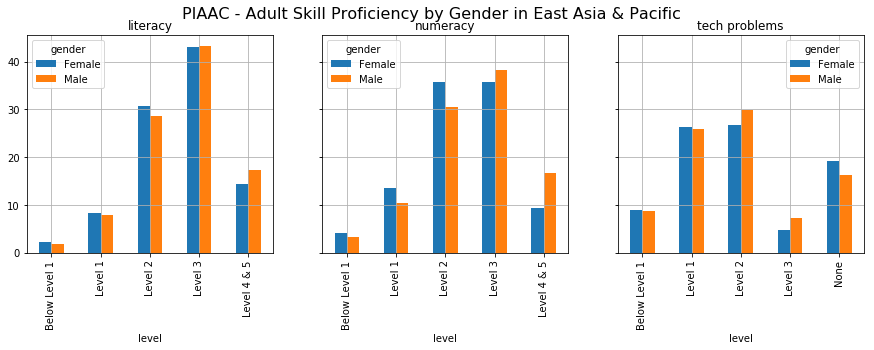

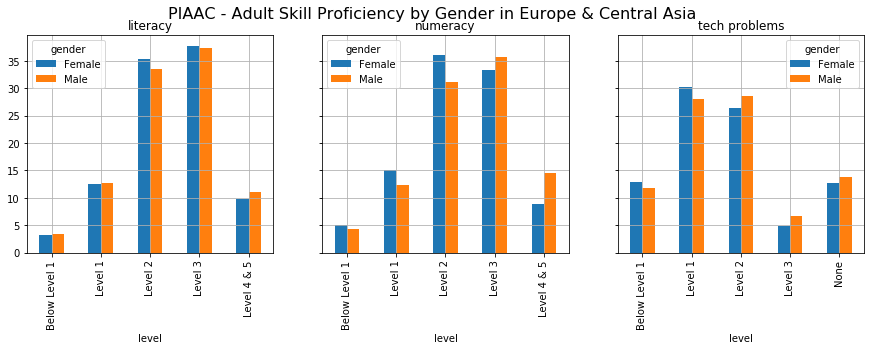

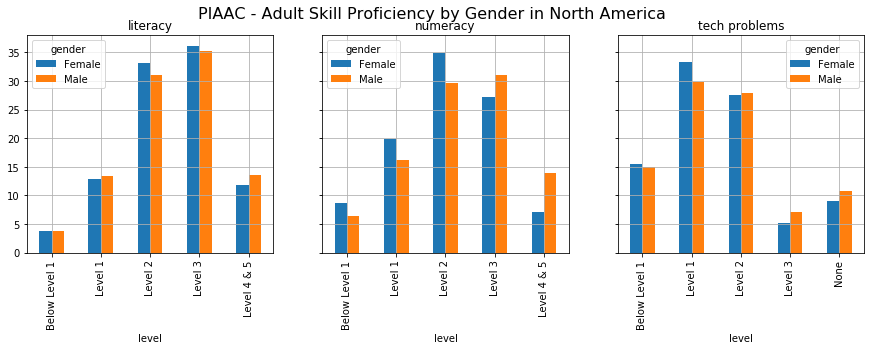

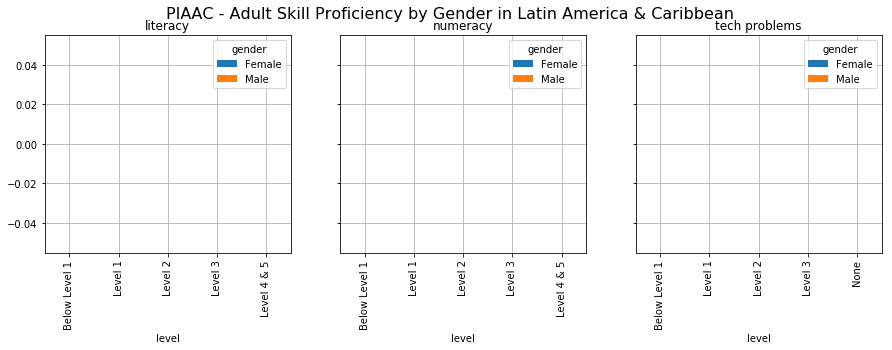

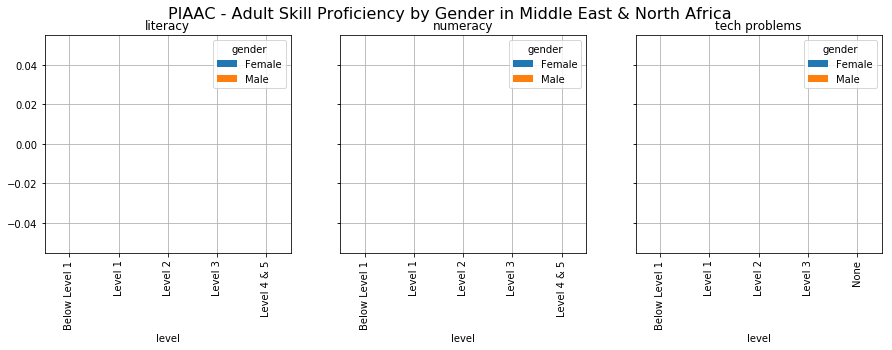

In [25]:
ls_subs = df_12['subject'].unique()
ls_gnds = ['Male', 'Female']
ls_regs = df_12['region'].unique()

for reg in ls_regs:
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
    for i, sub in enumerate(ls_subs):
        # select the relevant data
        df_tmp = df_12[(df_12['subject'] == sub) & (df_12['region'] == reg) & (df_12['gender'].isin(ls_gnds))].replace({'No computer experience or failed the ICT core test': 'None'})
        df_tmp.groupby(['gender', 'level']).mean().reset_index().pivot(index='level', columns='gender', values='ppl_perc').plot.bar(ax=axs[i], title=sub, grid=True)

    fig.suptitle("PIAAC - Adult Skill Proficiency by Gender in {}".format(reg), fontsize=16)

Se can see that the difference in literacy are quite low (with a slight bias towards male in higher skill levels). However, this bias becomes more pronounced for numeracy (and on level 3 of the tech problem solving skills)

## Correlation with other factors

Next we want to look at the correlation of gender skill levels to other economic factors. Therefore we will introduce broader categories for the skill levels (low, medium, high) and scatter the data:

In [87]:
df_12['level'].unique()

array(['Below Level 1', 'Level 1', 'Level 2', 'Level 3', 'Level 4',
       'Level 5', 'Failed the ICT Core Test', 'No computer experience',
       'Opted out of computer-based assessment', 'Level 4 & 5',
       'No computer experience or failed the ICT core test'], dtype=object)

In [88]:
# introduce new skill levels
df_12_sc = df_12
df_12_sc['level_coarse'] = df_12_sc['level']
lvl_dc = {'Level 2': 'Medium', 'Level 3': 'Medium', 'Level 4': 'High', 'Level 5': 'High', 'Level 4 & 5': 'High'}

def skill_ref(col):
    #print(col)
    if (col['subject'] == "tech problems"):
        col['level_coarse'] = 'High' if col['level_coarse'] == 'Level 3' else ('Medium' if col['level_coarse'] == 'Level 2' else 'Low')
    else:
        col['level_coarse'] = lvl_dc[col['level_coarse']] if col['level_coarse'] in lvl_dc else 'Low'
    return col
    
df_12_sc = df_12_sc.apply(skill_ref, axis=1)

df_12_len = df_12_sc.groupby(['country_name', 'country_code', 'region', 'gender', 'subject', 'level_coarse']).mean().reset_index()['edu_length']
df_12_tmp = df_12_sc.groupby(['country_name', 'country_code', 'region', 'gender', 'subject', 'level_coarse']).sum().reset_index().drop('edu_length', axis=1)
df_12_sc = pd.concat([df_12_tmp, df_12_len], axis=1)
df_12_sc.sample(5)

,country_name,country_code,region,gender,subject,level_coarse,ppl_perc,edu_length
542,Japan,JPN,East Asia & Pacific,Young,numeracy,Medium,75.045450,15.0
322,France,FRA,Europe & Central Asia,Male,literacy,Medium,68.652231,15.0
51,Austria,AUT,Europe & Central Asia,Male,tech problems,High,5.576622,15.0
947,Sweden,SWE,Europe & Central Asia,Male,tech problems,High,10.045474,16.0
769,Russian Federation,RUS,Europe & Central Asia,Female,tech problems,Low,59.150060,15.0


In [89]:
ls_col_reg = {
    'East Asia & Pacific': 'blue',
    'Europe & Central Asia': 'orange',
    'Middle East & North Africa': 'brown',
    'North America': 'darkorchid',
    'Latin America & Caribbean': 'green'
}
ls_reg = ['East Asia & Pacific', 'Europe & Central Asia', 'North America']

# values: region, edu_length, level, gender, ppl_perc

df_tmp = df_12_sc[(df_12_sc['gender'].isin(['Male', 'Female'])) & (df_12_sc['region'].isin(ls_reg))] \
    .groupby(['region', 'level_coarse', 'gender']).mean()[['ppl_perc']]

df_tmp.reset_index().pivot_table(index=['region', 'gender'], values='ppl_perc', columns='level_coarse').style.background_gradient(cmap='viridis')

#for gnd in ['Male', 'Female']:
#    df_tmp = df_12_sc[df_12_sc['gender'] == gnd]
#    df_tmp.groupby('level_coarse').mean().reset_index().pivot(index='edu_length', columns='level_coarse', values='ppl_perc').plot.bar()
    #df_tmp.plot.scatter(x='edu_length', y='ppl_perc', c=df_tmp['region'].apply(lambda x: ls_col_reg[x]))

In [90]:
df_tmp = df_12_sc[(df_12_sc['gender'].isin(['Male', 'Female'])) & (df_12_sc['region'].isin(ls_reg))] \
    .groupby(['edu_length', 'level_coarse', 'gender']).mean()[['ppl_perc']]

df_tmp.reset_index().pivot_table(index=['edu_length', 'gender'], values='ppl_perc', columns='level_coarse').style.background_gradient(cmap='viridis')

The differences appear to be invariant to the length of education.

In [94]:
# check the countries with the highest differences
df_12_agg = df_12_sc[df_12_sc['gender'] == 'Female']
df_12_agg = df_12_agg.merge(df_12_sc[df_12_sc['gender'] == 'Male'], on=['country_code', 'level_coarse', 'subject'])
df_12_agg['diff_mf'] = df_12_agg['ppl_perc_y'] - df_12_agg['ppl_perc_x']

df_12_sc[df_12_sc['gender'].isin(['Male', 'Female'])].replace({0: np.nan})\
    .pivot_table(index=['country_name', 'subject'], columns=['level_coarse', 'gender'], values='ppl_perc')\
    .style.background_gradient(cmap='viridis')

#df_12_agg[['country_code', 'region_x', 'country_name_x', 'subject', 'level_coarse', 'diff_mf']].sort_values(by='diff_mf').style.bar(subset=['diff_mf'], align='mid', color=['#d65f5f', '#5fba7d'])

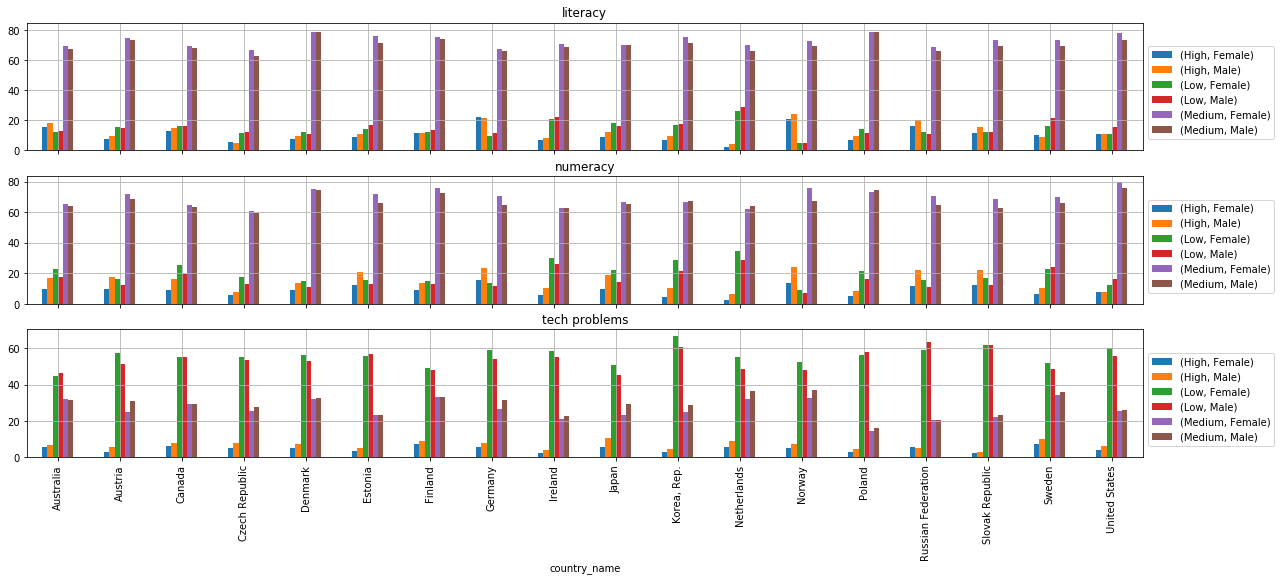

In [101]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 8))
for i, sub in enumerate(['literacy', 'numeracy', 'tech problems']):
    df_12_sc[(df_12_sc['gender'].isin(['Male', 'Female'])) & (df_12_sc['subject'] == sub)].replace({0: np.nan})\
        .pivot_table(index=['country_name'], columns=['level_coarse', 'gender'], values='ppl_perc')\
        .plot.bar(title=sub, ax=axs[i], grid=True)
    patches, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(patches, labels, loc='lower left', bbox_to_anchor=(1., .05, .0, .0));

## Conclusion

What we can see from the data 